# Build a five-layer LSTM network with a hidden size of 256 for a text classification task. The model is trained on the UIT-VSFC (Vietnamese Student Feedback Corpus) dataset using Adam as the optimization method, and its performance is evaluated using the F1 score

### Bộ dữ liệu sử dụng: [UIT-VSFC](https://drive.google.com/drive/folders/1rdcXNGt_3-QUvV8EtSvVsLMVeHmk6Yqk?usp=drive_link) và [PhoNERT](https://github.com/VinAIResearch/PhoNER_COVID19).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import json
import numpy as np
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
file_path = './dataset/UIT-VSFC'

In [4]:
class EarlyStopping:
    """Early stopping to stop training when validation F1 doesn't improve"""
    def __init__(self, patience=5, min_delta=0.0001, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): Print messages when saving model
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = 0

    def __call__(self, val_f1, model, path='best_model.pt'):
        """Check if should stop training and save best model"""
        score = val_f1

        if self.best_score is None:
            # First epoch
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model, path)
        elif score < self.best_score + self.min_delta:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model, path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, path):
        """Save model when validation F1 improves"""
        if self.verbose:
            print(f'  → Validation F1 improved ({self.best_f1:.4f} --> {val_f1:.4f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.best_f1 = val_f1


In [5]:
class Vocabulary:
    """Build vocabulary from training data"""
    def __init__(self, max_vocab_size=20000):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.max_vocab_size = max_vocab_size

    def build_vocab(self, sentences):
        """Build vocabulary from list of sentences"""
        word_freq = Counter()
        for sentence in sentences:
            words = sentence.lower().split()
            word_freq.update(words)

        # Keep most common words
        most_common = word_freq.most_common(self.max_vocab_size - 2)

        for idx, (word, _) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, sentence):
        """Convert sentence to list of indices"""
        words = sentence.lower().split()
        return [self.word2idx.get(word, 1) for word in words]  # 1 is <UNK>

In [6]:
class VSFCDataset(Dataset):
    """Dataset class for UIT-VSFC"""
    def __init__(self, file_path, vocab=None, label_encoder=None, is_train=False):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)

        self.sentences = [item['sentence'] for item in self.data]
        self.labels = [item['sentiment'] for item in self.data]

        # Build vocabulary on training set
        if is_train:
            self.vocab = Vocabulary()
            self.vocab.build_vocab(self.sentences)

            # Build label encoder
            unique_labels = sorted(set(self.labels))
            self.label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
            print(f"Labels: {self.label_encoder}")
        else:
            self.vocab = vocab
            self.label_encoder = label_encoder

        # Encode sentences and labels
        self.encoded_sentences = [self.vocab.encode(sent) for sent in self.sentences]
        self.encoded_labels = [self.label_encoder[label] for label in self.labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded_sentences[idx]), torch.tensor(self.encoded_labels[idx])

In [7]:
def collate_fn(batch):
    """Custom collate function to pad sequences"""
    sentences, labels = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return sentences_padded, labels

In [8]:
class FiveLayerLSTM(nn.Module):
    """5-layer LSTM for text classification"""
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, dropout=0.5):
        super(FiveLayerLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # 5 LSTM layers
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.lstm5 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)

        # Pass through 5 LSTM layers
        out, _ = self.lstm1(embedded)
        out = self.dropout(out)

        out, _ = self.lstm2(out)
        out = self.dropout(out)

        out, _ = self.lstm3(out)
        out = self.dropout(out)

        out, _ = self.lstm4(out)
        out = self.dropout(out)

        out, _ = self.lstm5(out)

        # Use the last hidden state
        # dùng để lấy vector hidden ở time-step cuối của mỗi câu, coi như biểu diễn ngữ nghĩa toàn câu để đưa vào lớp phân loại
        out = out[:, -1, :]
        out = self.dropout(out)

        # Classification layer
        out = self.fc(out)
        return out

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for sentences, labels in tqdm(dataloader, desc="Training", leave=False):
        sentences, labels = sentences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sentences)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1

In [10]:
def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sentences, labels in dataloader:
            sentences, labels = sentences.to(device), labels.to(device)

            outputs = model(sentences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, all_preds, all_labels

In [12]:
def main():
    # Hyperparameters
    EMBEDDING_DIM = 128
    HIDDEN_SIZE = 256
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    PATIENCE = 7  # Stop if no improvement for 7 epochs
    MIN_DELTA = 0.0001  # Minimum improvement to count as progress

    # Load datasets
    print("Loading datasets...")
    train_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-train.json', is_train=True)
    dev_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-dev.json',
                              vocab=train_dataset.vocab,
                              label_encoder=train_dataset.label_encoder)
    test_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-test.json',
                               vocab=train_dataset.vocab,
                               label_encoder=train_dataset.label_encoder)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, collate_fn=collate_fn)

    # Initialize model
    vocab_size = len(train_dataset.vocab.word2idx)
    num_classes = len(train_dataset.label_encoder)

    model = FiveLayerLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, num_classes).to(device)
    print(f"\nModel architecture:\n{model}")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

    # Training loop
    train_losses, dev_losses = [], []
    train_f1s, dev_f1s = [], []

    print(f"\nStarting training with early stopping (patience={PATIENCE})...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
        dev_loss, dev_f1, _, _ = evaluate(model, dev_loader, criterion, device)

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        train_f1s.append(train_f1)
        dev_f1s.append(dev_f1)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"  Dev Loss: {dev_loss:.4f}, Dev F1: {dev_f1:.4f}")

        # Early stopping check
        early_stopping(dev_f1, model, path='best_model.pt')

        if early_stopping.early_stop:
            print(f"\n{'='*50}")
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation F1: {early_stopping.best_f1:.4f}")
            print(f"{'='*50}\n")
            break

    # Load best model and evaluate on test set
    print("Loading best model for test evaluation...")
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

    print(f"\n{'='*50}")
    print(f"Final Test Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test F1 (Macro): {test_f1:.4f}")
    print(f"  Best Dev F1: {early_stopping.best_f1:.4f}")
    print(f"  Total Epochs Trained: {len(train_losses)}")
    print(f"{'='*50}")

    print("\nDetailed Classification Report:")
    print(classification_report(test_labels, test_preds,
                                target_names=[k for k, v in sorted(train_dataset.label_encoder.items(),
                                                                   key=lambda x: x[1])]))

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=3)
    plt.plot(dev_losses, label='Dev Loss', marker='s', markersize=3)
    plt.axvline(x=len(train_losses) - PATIENCE - 1, color='r', linestyle='--',
                label='Best Model', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1', marker='o', markersize=3)
    plt.plot(dev_f1s, label='Dev F1', marker='s', markersize=3)
    plt.axvline(x=len(train_f1s) - PATIENCE - 1, color='r', linestyle='--',
                label='Best Model', alpha=0.7)
    plt.axhline(y=early_stopping.best_f1, color='g', linestyle=':',
                label=f'Best F1: {early_stopping.best_f1:.4f}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves_early_stopping.png', dpi=300, bbox_inches='tight')
    print("\nTraining curves saved as 'training_curves_early_stopping.png'")

Loading datasets...
Vocabulary size: 2516
Labels: {'negative': 0, 'neutral': 1, 'positive': 2}

Model architecture:
FiveLayerLSTM(
  (embedding): Embedding(2516, 128, padding_idx=0)
  (lstm1): LSTM(128, 256, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 256, batch_first=True, bidirectional=True)
  (lstm3): LSTM(512, 256, batch_first=True, bidirectional=True)
  (lstm4): LSTM(512, 256, batch_first=True, bidirectional=True)
  (lstm5): LSTM(512, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

Total parameters: 7,421,955

Starting training with early stopping (patience=7)...


Epoch 1/50
  Train Loss: 0.7778, Train F1: 0.4196
  Dev Loss: 0.7051, Dev F1: 0.5032
  → Validation F1 improved (0.5032 --> 0.5032). Saving model...


Epoch 2/50
  Train Loss: 0.6932, Train F1: 0.4998
  Dev Loss: 0.7276, Dev F1: 0.4680
  EarlyStopping counter: 1/7


Epoch 3/50
  Train Loss: 0.6993, Train F1: 0.4879
  Dev Loss: 0.7368, Dev F1: 0.4494
  EarlyStopping counter: 2/7


Epoch 4/50
  Train Loss: 0.7284, Train F1: 0.4552
  Dev Loss: 0.7256, Dev F1: 0.4620
  EarlyStopping counter: 3/7


Epoch 5/50
  Train Loss: 0.6403, Train F1: 0.5058
  Dev Loss: 0.5461, Dev F1: 0.5500
  → Validation F1 improved (0.5500 --> 0.5500). Saving model...


Epoch 6/50
  Train Loss: 0.4889, Train F1: 0.5693
  Dev Loss: 0.4039, Dev F1: 0.5966
  → Validation F1 improved (0.5966 --> 0.5966). Saving model...


Epoch 7/50
  Train Loss: 0.3977, Train F1: 0.5949
  Dev Loss: 0.4059, Dev F1: 0.6055
  → Validation F1 improved (0.6055 --> 0.6055). Saving model...


Epoch 8/50
  Train Loss: 0.3781, Train F1: 0.6017
  Dev Loss: 0.3603, Dev F1: 0.6061
  → Validation F1 improved (0.6061 --> 0.6061). Saving model...


Epoch 9/50
  Train Loss: 0.3322, Train F1: 0.6131
  Dev Loss: 0.3465, Dev F1: 0.6101
  → Validation F1 improved (0.6101 --> 0.6101). Saving model...


Epoch 10/50
  Train Loss: 0.2943, Train F1: 0.6199
  Dev Loss: 0.3358, Dev F1: 0.6158
  → Validation F1 improved (0.6158 --> 0.6158). Saving model...


Epoch 11/50
  Train Loss: 0.2763, Train F1: 0.6250
  Dev Loss: 0.3229, Dev F1: 0.6090
  EarlyStopping counter: 1/7


Epoch 12/50
  Train Loss: 0.2519, Train F1: 0.6302
  Dev Loss: 0.3045, Dev F1: 0.6636
  → Validation F1 improved (0.6636 --> 0.6636). Saving model...


Epoch 13/50
  Train Loss: 0.2247, Train F1: 0.7002
  Dev Loss: 0.3123, Dev F1: 0.6796
  → Validation F1 improved (0.6796 --> 0.6796). Saving model...


Epoch 14/50
  Train Loss: 0.2099, Train F1: 0.7685
  Dev Loss: 0.2993, Dev F1: 0.7529
  → Validation F1 improved (0.7529 --> 0.7529). Saving model...


Epoch 15/50
  Train Loss: 0.1926, Train F1: 0.7993
  Dev Loss: 0.3045, Dev F1: 0.7589
  → Validation F1 improved (0.7589 --> 0.7589). Saving model...


Epoch 16/50
  Train Loss: 0.1970, Train F1: 0.8011
  Dev Loss: 0.3255, Dev F1: 0.6115
  EarlyStopping counter: 1/7


Epoch 17/50
  Train Loss: 0.2322, Train F1: 0.6773
  Dev Loss: 0.2966, Dev F1: 0.7583
  EarlyStopping counter: 2/7


Epoch 18/50
  Train Loss: 0.1836, Train F1: 0.7936
  Dev Loss: 0.2839, Dev F1: 0.7292
  EarlyStopping counter: 3/7


Epoch 19/50
  Train Loss: 0.1701, Train F1: 0.8349
  Dev Loss: 0.3122, Dev F1: 0.7712
  → Validation F1 improved (0.7712 --> 0.7712). Saving model...


Epoch 20/50
  Train Loss: 0.1550, Train F1: 0.8530
  Dev Loss: 0.3232, Dev F1: 0.7709
  EarlyStopping counter: 1/7


Epoch 21/50
  Train Loss: 0.1544, Train F1: 0.8590
  Dev Loss: 0.3492, Dev F1: 0.7320
  EarlyStopping counter: 2/7


Epoch 22/50
  Train Loss: 0.1449, Train F1: 0.8722
  Dev Loss: 0.3250, Dev F1: 0.7637
  EarlyStopping counter: 3/7


Epoch 23/50
  Train Loss: 0.1383, Train F1: 0.8795
  Dev Loss: 0.3380, Dev F1: 0.7910
  → Validation F1 improved (0.7910 --> 0.7910). Saving model...


Epoch 24/50
  Train Loss: 0.1233, Train F1: 0.8970
  Dev Loss: 0.3066, Dev F1: 0.7516
  EarlyStopping counter: 1/7


Epoch 25/50
  Train Loss: 0.1207, Train F1: 0.8999
  Dev Loss: 0.3524, Dev F1: 0.7706
  EarlyStopping counter: 2/7


Epoch 26/50
  Train Loss: 0.1277, Train F1: 0.8981
  Dev Loss: 0.3280, Dev F1: 0.7643
  EarlyStopping counter: 3/7


Epoch 27/50
  Train Loss: 0.1177, Train F1: 0.9058
  Dev Loss: 0.3447, Dev F1: 0.7796
  EarlyStopping counter: 4/7


Epoch 28/50
  Train Loss: 0.1208, Train F1: 0.9022
  Dev Loss: 0.3739, Dev F1: 0.7694
  EarlyStopping counter: 5/7


Epoch 29/50
  Train Loss: 0.1111, Train F1: 0.9201
  Dev Loss: 0.3516, Dev F1: 0.7626
  EarlyStopping counter: 6/7


Epoch 30/50
  Train Loss: 0.0980, Train F1: 0.9263
  Dev Loss: 0.3672, Dev F1: 0.7710
  EarlyStopping counter: 7/7

Early stopping triggered at epoch 30
Best validation F1: 0.7910

Loading best model for test evaluation...

Final Test Results:
  Test Loss: 0.4192
  Test F1 (Macro): 0.7461
  Best Dev F1: 0.7910
  Total Epochs Trained: 30

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.93      0.92      1409
     neutral       0.42      0.38      0.40       167
    positive       0.94      0.91      0.93      1590

    accuracy                           0.89      3166
   macro avg       0.75      0.74      0.75      3166
weighted avg       0.89      0.89      0.89      3166


Training curves saved as 'training_curves_early_stopping.png'


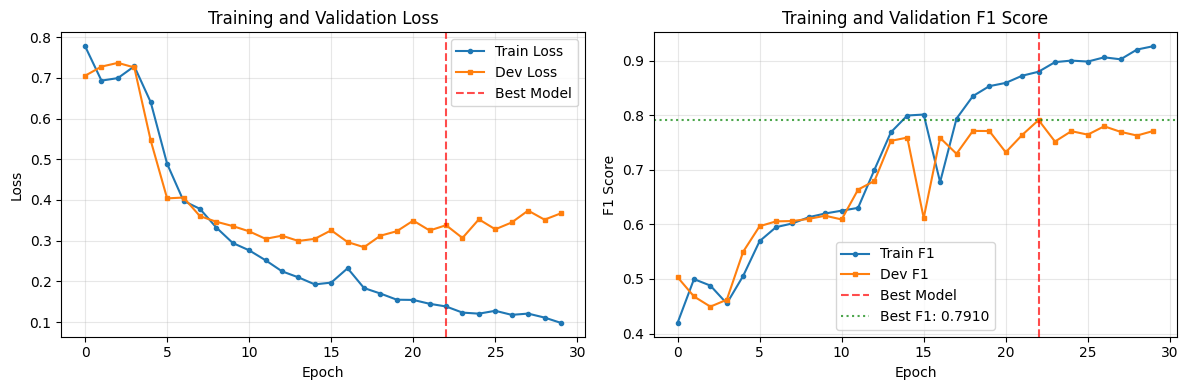

In [13]:
if __name__ == "__main__":
    main()

In [14]:
def predict_sentence(model, sentence, vocab, label_encoder, device):
    model.eval()

    # Encode sentence
    encoded = vocab.encode(sentence)
    input_tensor = torch.tensor(encoded).unsqueeze(0).to(device)
    # shape: (1, seq_len)

    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = torch.argmax(outputs, dim=1).item()

    # Decode label
    idx2label = {v: k for k, v in label_encoder.items()}
    return idx2label[pred_idx]

In [16]:
train_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-train.json', is_train=True)
dev_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-dev.json',
                              vocab=train_dataset.vocab,
                              label_encoder=train_dataset.label_encoder)
test_dataset = VSFCDataset('./dataset/UIT-VSFC/UIT-VSFC-test.json',
                               vocab=train_dataset.vocab,
                               label_encoder=train_dataset.label_encoder)

Vocabulary size: 2516
Labels: {'negative': 0, 'neutral': 1, 'positive': 2}


In [18]:
# Khởi tạo model
model = FiveLayerLSTM(
    vocab_size=len(train_dataset.vocab.word2idx),
    embedding_dim=128,
    hidden_size=256,
    num_classes=len(train_dataset.label_encoder)
).to(device)

# Load trọng số
model.load_state_dict(torch.load("best_model.pt", map_location=device))

<All keys matched successfully>

In [19]:
sentence = "thầy giảng bài rất dễ hiểu và nhiệt tình"
prediction = predict_sentence(
    model,
    sentence,
    train_dataset.vocab,
    train_dataset.label_encoder,
    device
)

print(f"Câu: {sentence}")
print(f"Dự đoán sentiment: {prediction}")

Câu: thầy giảng bài rất dễ hiểu và nhiệt tình
Dự đoán sentiment: positive


In [28]:
sentence = "thầy giảng bài tệ"
prediction = predict_sentence(
    model,
    sentence,
    train_dataset.vocab,
    train_dataset.label_encoder,
    device
)

print(f"Câu: {sentence}")
print(f"Dự đoán sentiment: {prediction}")

Câu: thầy giảng bài tệ
Dự đoán sentiment: negative


In [32]:
sentence = "thầy giảng tạm trung bình"
prediction = predict_sentence(
    model,
    sentence,
    train_dataset.vocab,
    train_dataset.label_encoder,
    device
)

print(f"Câu: {sentence}")
print(f"Dự đoán sentiment: {prediction}")

Câu: thầy giảng khá trung bình
Dự đoán sentiment: positive
